# Applying network methdologies to extract meaningfull links between actors and movies

In [2]:
import networkx as nx

import pandas as pd
from operator import itemgetter
import matplotlib.pyplot as plt
import collections
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman
import itertools
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# scrapping

import requests
from bs4 import BeautifulSoup


In [3]:
# Open movie dataset
df_movie = pd.read_csv('../Datasets/movies_cleaned_dataset.csv')
df_movie.Top_genres.replace('Action/Adventure', 'Action_Adventure', inplace=True)

In [4]:
# Find movies with Oscar wins
df_awarded = df_movie[df_movie.Oscar_Wins > 0]
df_awarded.head()

,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_genres,Main_genre,Main_language,Top_genres,Main_country,Main_continent,Plot_summary,...,averageRating,numVotes,Estimated_Budget,IMDb,Oscar_Wins,Nominations,Profit,Inflation_adjusted_profit,nconst,Director_name
5,Henry V,10161099,137.0,"{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...","['Costume drama', 'War film', 'Epic', 'Period ...",English Language,Drama,United Kingdom,Europe,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,...,7.5,31193.0,9000000,tt0097499,1,3,1161099,2.217323e+06,nm0000110,Kenneth Branagh
8,Mary Poppins,102272727,139.0,"{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...","[""Children's/Family"", 'Musical', 'Fantasy', 'C...",English Language,Family,United States of America,USA,The film opens with Mary Poppins perched in a...,...,7.8,181710.0,6000000,tt0058331,5,13,96272727,7.348061e+08,nm0829038,Robert Stevenson
112,Midnight Express,35000000,121.0,"{""/m/01jfsb"": ""Thriller"", ""/m/0hn10"": ""LGBT"", ...","['Thriller', 'LGBT', 'Indie', 'Crime Fiction',...",Multilingual,Drama,United States of America,NaN,"On October 6, 1970, while on holiday in Istanb...",...,7.5,86520.0,2300000,tt0077928,2,6,32700000,1.186705e+08,nm0000570,Alan Parker
144,Sweeney Todd: The Demon Barber of Fleet Street,152523164,117.0,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/0fx2s"": ""Tra...","['Crime Fiction', 'Tragedy', 'Horror', 'Supern...",English Language,Horror,United States of America,NaN,"In the 19th century, Benjamin Barker , a skill...",...,7.3,381643.0,50000000,tt0408236,1,3,102523164,1.170573e+08,nm0000318,Tim Burton
171,Black Rider,0,12.0,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/0219x_"": ""In...","['Crime Fiction', 'Indie', 'Crime Drama', 'Bla...",German Language,Other,Germany,Europe,"A motorbiker , who early in the film was unabl...",...,7.6,1868.0,0,NaN,1,1,0,0.000000e+00,nm0200500,Pepe Danquart


In [5]:
df_awarded.tconst

5        tt0097499
8        tt0058331
112      tt0077928
144      tt0408236
171      tt0108056
           ...    
41918    tt1832382
41924    tt0041587
42012    tt0034498
42070    tt0112818
42087    tt0382734
Name: tconst, Length: 698, dtype: object

In [6]:
# Open cast dataset
df_cast = pd.read_csv('../Datasets/cast_processed.csv')
df_cast.head()

,Movie_name,Top_genres,Release_Date,tconst,capped_profit,Successful,role_1,role_2,role_3,role_4,...,role_3_birth_year,role_4_birth_year,role_1_roles_count,role_2_roles_count,role_3_roles_count,role_4_roles_count,role_1_sex,role_2_sex,role_3_sex,role_4_sex
0,Ghosts of Mars,Drama,2001,tt0228333,-1.870336e+07,3.9,nm0000449,nm0001084,nm0000427,nm0005458,...,1949,1967,133.0,43.0,52.0,53.0,F,M,F,M
1,White Of The Eye,Drama,1987,tt0094320,0.000000e+00,4.5,nm0001418,nm0001550,nm0742165,nm0262543,...,1950,1942,68.0,40.0,115.0,25.0,M,F,M,M
2,Little city,Drama,1997,tt0119548,0.000000e+00,4.4,nm0000954,nm0000542,nm0068725,nm0255588,...,1932,1922,21.0,65.0,5.0,1.0,M,F,M,M
3,Henry V,Drama,1989,tt0097499,2.217323e+06,5.5,nm0000110,nm0001394,nm0791871,nm0488289,...,1956,\N,148.0,187.0,30.0,12.0,M,M,M,M
4,Baby Boy,Drama,2001,tt0255819,1.160929e+07,4.7,nm0942189,nm0879085,nm0378245,nm0328954,...,1970,1976,1.0,31.0,134.0,163.0,F,M,F,M


In [7]:
# join awarded movies with cast

df_awarded = df_awarded.join(df_cast.set_index('tconst'), on='tconst', how='left', rsuffix='_cast')
df_awarded = df_awarded.reset_index()

In [8]:
df_awarded.columns  

Index(['index', 'Movie_name', 'Movie_box_office_revenue', 'Movie_runtime',
       'Movie_genres', 'Main_genre', 'Main_language', 'Top_genres',
       'Main_country', 'Main_continent', 'Plot_summary', 'Release_Date',
       'tconst', 'averageRating', 'numVotes', 'Estimated_Budget', 'IMDb',
       'Oscar_Wins', 'Nominations', 'Profit', 'Inflation_adjusted_profit',
       'nconst', 'Director_name', 'Movie_name_cast', 'Top_genres_cast',
       'Release_Date_cast', 'capped_profit', 'Successful', 'role_1', 'role_2',
       'role_3', 'role_4', 'role_1_birth_year', 'role_2_birth_year',
       'role_3_birth_year', 'role_4_birth_year', 'role_1_roles_count',
       'role_2_roles_count', 'role_3_roles_count', 'role_4_roles_count',
       'role_1_sex', 'role_2_sex', 'role_3_sex', 'role_4_sex'],
      dtype='object')

In [9]:
df_awarded.reset_index(inplace=True)

df_actors_awarded = df_awarded[['role_1', 'role_2', 'role_3', 'role_4']].dropna()

In [10]:
actors = df_actors_awarded.values
actors = actors.flatten()

In [11]:
actors.shape

(1552,)

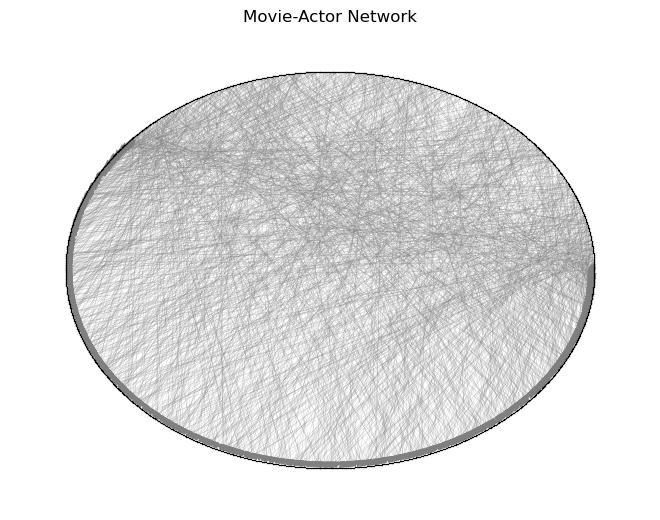

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named df with the columns described in your question
# Example data (replace this with your actual DataFrame)
df = df_awarded.head(1000)

# Create a directed graph
G = nx.DiGraph()

# Add nodes for movies and actors
movies = df['Movie_name'].unique()
actors = set(df[['role_1', 'role_2', 'role_3', 'role_4']].values.flatten())

G.add_nodes_from(movies, node_type='movie')
G.add_nodes_from(actors, node_type='actor')

# Add edges between movies and actors
for index, row in df.iterrows():
    movie_name = row['Movie_name']
    for role_column in ['role_1', 'role_2', 'role_3', 'role_4']:
        actor_id = row[role_column]
        if pd.notna(actor_id):  # Skip NaN values
            G.add_edge(movie_name, actor_id)

# Draw the graph
pos = nx.spring_layout(G)  # You can use different layout algorithms
#nx.draw(G, pos, with_labels=False, node_size=10, font_size=8, node_color='skyblue', font_color='black', font_weight='bold', alpha=0.7)
#plt.title('Movie-Actor Network')
#plt.show()


options = {
    "node_color": "black",
    "node_size": 1,
    "edge_color": "gray",
    "linewidths": 0,
    "width": 0.1,
}
nx.draw_circular(G, **options)
plt.title('Awarded Movie-Actor Network')
plt.show()

In [13]:
import networkx as nx

# Assuming G is your graph
degree_centrality = nx.degree_centrality(G)

# Get the most famous actor(s)
most_famous_actors = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:20]
# only keep name starting with 'nm'
most_famous_actors = [actor for actor in most_famous_actors if actor.startswith('nm')]
                      

print("Most famous actors:", most_famous_actors)


Most famous actors: ['nm0000009', 'nm0000163', 'nm0000164', 'nm0000493', 'nm0000034', 'nm0000012', 'nm0000059', 'nm0000404', 'nm0000008', 'nm0000197', 'nm0000060', 'nm0000044', 'nm0000138', 'nm0000006', 'nm0000134', 'nm0000354', 'nm0001859', 'nm0000146']


In [14]:
degree_centrality

{'Henry V': 0.0022396416573348264,
 'Mary Poppins': 0.0,
 'Midnight Express': 0.0022396416573348264,
 'Sweeney Todd: The Demon Barber of Fleet Street': 0.0,
 'Black Rider': 0.0,
 'Green Dolphin Street': 0.0022396416573348264,
 'The Prime of Miss Jean Brodie': 0.0022396416573348264,
 'Shaft': 0.0022396416573348264,
 'San Francisco': 0.0022396416573348264,
 'The Iron Lady': 0.0022396416573348264,
 'My Fair Lady': 0.0,
 'Holiday Inn': 0.0,
 'The Pride of the Yankees': 0.0022396416573348264,
 'Mediterraneo': 0.0022396416573348264,
 'The Killing Fields': 0.0022396416573348264,
 'Laura': 0.0022396416573348264,
 'The Last Picture Show': 0.0022396416573348264,
 'Zorba the Greek': 0.0022396416573348264,
 'Lovers and Other Strangers': 0.0,
 'Harry and Tonto': 0.0022396416573348264,
 'Shine': 0.0,
 "Prizzi's Honor": 0.0,
 'Dirty Dancing': 0.0,
 'Anastasia': 0.0022396416573348264,
 'L.A. Confidential': 0.0022396416573348264,
 'The Omen': 0.0,
 'Giant': 0.0,
 'Kentucky': 0.0022396416573348264,
 'Me